In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from matplotlib import pylab as plt
import numpy as np

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
trainset = torchvision.datasets.mnist.MNIST('../data/', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.mnist.MNIST('../data/', train=False, download=True, transform=test_transform)

In [4]:
trainset[0][0].size()

torch.Size([1, 28, 28])

In [5]:
len(trainset), len(testset), len(trainset.classes)

(60000, 10000, 10)

In [6]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, num_workers=2)

In [7]:
trainiter = iter(trainloader)

In [8]:
def show_img(img):
    img = img.numpy()
    img = np.transpose(img, [1, 2, 0])
    plt.axis('off')
    plt.imshow(img)

In [9]:
example_imgs, example_labels = next(trainiter)
example_grid = torchvision.utils.make_grid(example_imgs)
example_imgs.size(), example_labels[:5]

(torch.Size([32, 1, 28, 28]), tensor([8, 1, 0, 5, 7]))

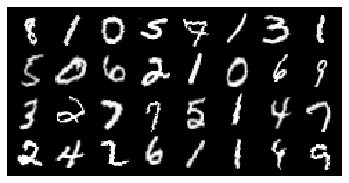

In [10]:
show_img(example_grid)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.fc4 = nn.Linear(64 * 7 * 7, 10)
        self._init_weights()
        
    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(layer.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.fc4(x)
        return x

In [12]:
net = Net()

In [13]:
def train(net, trainloader, epochs=3, lr=0.001, history_step=200):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    history_loss = []
    
    for epoch in range(epochs):
        for step, data in enumerate(trainloader):
            imgs, labels = data
            imgs = imgs.to(device)
            lables = labels.to(device)
            outputs = net(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step % history_step == history_step - 1:
                print(f"epoch: {epoch + 1} -- step: {step + 1} -- loss: {loss:.4f}")
                history_loss.append(loss)

In [14]:
train(net, trainloader)

epoch: 1 -- step: 200 -- loss: 0.3918
epoch: 1 -- step: 400 -- loss: 0.0268
epoch: 1 -- step: 600 -- loss: 0.1308
epoch: 1 -- step: 800 -- loss: 0.4800
epoch: 1 -- step: 1000 -- loss: 0.0574
epoch: 1 -- step: 1200 -- loss: 0.5029
epoch: 1 -- step: 1400 -- loss: 0.0252
epoch: 1 -- step: 1600 -- loss: 0.0446
epoch: 1 -- step: 1800 -- loss: 0.2819
epoch: 2 -- step: 200 -- loss: 0.0149
epoch: 2 -- step: 400 -- loss: 0.0332
epoch: 2 -- step: 600 -- loss: 0.0014
epoch: 2 -- step: 800 -- loss: 0.0862
epoch: 2 -- step: 1000 -- loss: 0.0844
epoch: 2 -- step: 1200 -- loss: 0.0046
epoch: 2 -- step: 1400 -- loss: 0.2340
epoch: 2 -- step: 1600 -- loss: 0.0013
epoch: 2 -- step: 1800 -- loss: 0.0249
epoch: 3 -- step: 200 -- loss: 0.3044
epoch: 3 -- step: 400 -- loss: 0.0440
epoch: 3 -- step: 600 -- loss: 0.0020
epoch: 3 -- step: 800 -- loss: 0.0102
epoch: 3 -- step: 1000 -- loss: 0.0123
epoch: 3 -- step: 1200 -- loss: 0.0876
epoch: 3 -- step: 1400 -- loss: 0.0012
epoch: 3 -- step: 1600 -- loss: 0.067

In [15]:
def evaluate(net, dataloader):
    corrects = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            outputs = net(imgs)
            predictions = outputs.argmax(dim=1)
            corrects += (predictions == labels).sum()
            total += outputs.size()[0]
    
    return corrects.numpy() / total

In [16]:
evaluate(net, trainloader)

0.9829333333333333

In [17]:
evaluate(net, testloader)

0.9904